In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from spectres import spectres
from scipy.constants import c as speed_of_light
from tqdm import tqdm
import prodimopy.read as pread
import prodimopy.plot as pplot
from numba import njit
from scipy.stats import kendalltau, spearmanr, pearsonr
from scipy.signal import correlate, fftconvolve
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [54]:
def calc_flux(wl, flux, wlrange):
    """
    Calculates the flux of a flux density in Jy over a range of wavelengths in microns
    """
    mask = (wl >= wlrange[0]) & (wl <= wlrange[1])
    return total_flux(wl[mask], flux[mask])


def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    if wl.size == 0:
        return 0
    flux_lambda = (speed_of_light * 100 / (wl * 1e-4) ** 2) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux

def add_noise(flux, SNR=300):
    """
    SNR = flux/sigma
    """
    noise_level = np.min(flux) / SNR
    noise = np.random.normal(0, noise_level, size=flux.shape)
    return flux + noise

In [55]:
with open('FLiTsData1000.pkl', 'rb') as f:
    df = pickle.load(f)

In [56]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

In [57]:
species = ['NO']
X = []
y = []
total_wl = np.linspace(4.9, 6.5, 1024)
for i, row in tqdm(df.iterrows()):
    if i in [10, 15, 16, 20, 21, 22]:
        continue
    for _ in range(400):
        wl = row['FLiTs Wavelength']
        NH3_wl = row['FLiTs NH3 Wavelength']
        NH3_flux = np.interp(total_wl, NH3_wl, row['FLiTs NH3 Flux'])
        flux = np.interp(total_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
        flux_cont = np.interp(total_wl, wl, row['FLiTs Flux Continuum'])
        flux = add_noise(flux, SNR=300)-flux_cont + NH3_flux
        dat = []
        for specie in species:
            specie_wl = row[f'FLiTs {specie} Wavelength']
            specie_flux = row[f'FLiTs {specie} Flux']
            specie_flux = np.interp(total_wl, specie_wl, specie_flux)
            flux -= specie_flux
            specie_flux = np.random.uniform(0, 2) * specie_flux
            # specie_flux += np.random.normal(0, abs(np.mean(specie_flux)), len(specie_flux))
            flux += specie_flux
            dat.append(specie_flux)
        X.append(flux)
        y.append(dat)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

3it [00:04,  1.66s/it]


KeyboardInterrupt: 

In [6]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super().__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.downsample = downsample or (
            nn.Conv1d(in_channels, out_channels, 1)
            if in_channels != out_channels else nn.Identity()
        )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class SpectralResNet(nn.Module):
    def __init__(self, input_length=10000, num_species=11):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            ResidualBlock1D(32, 64),
            nn.MaxPool1d(2),

            ResidualBlock1D(64, 128),
            nn.MaxPool1d(2),

            ResidualBlock1D(128, 256),
            nn.MaxPool1d(2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),                          # (B, 128 * 1250)
            nn.Linear(256 * (input_length // 16), 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 256 * (input_length // 16)),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, input_length // 16)),

            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),  # -> (B, 64, 2500)
            nn.ReLU(),

            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),  # -> (B, 64, 2500)
            nn.ReLU(),

            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),  # -> (B, 32, 5000)
            nn.ReLU(),

            nn.ConvTranspose1d(32, num_species, kernel_size=4, stride=2, padding=1),  # -> (B, 11, 10000)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, 10000)
        x = self.encoder(x)
        x = self.fc(x)
        x = self.decoder(x)
        return x


In [7]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = SpectralResNet(input_length=1024, num_species=len(species))

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
loss_fn = nn.SmoothL1Loss()

num_epochs = 300
print_interval = 100
for epoch in tqdm(range(num_epochs)):
    model.train()
    if epoch % 10 == 0:
        learning_rate = 1e-5 * 0.9 ** (epoch//10)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epoch_loss = 0.0  # To track total loss for the current epoch
    for batch_idx, (xb, yb) in enumerate(dataloader):
        optimizer.zero_grad()

        # Forward pass
        pred = model(xb)

        # Compute loss
        loss = loss_fn(pred, yb)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track the loss for the epoch
        epoch_loss += loss.item()

        # Print the loss at specified intervals
        if (batch_idx + 1) % print_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.2e}")
            # pass

    # Print average loss for the entire epoch
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_epoch_loss:.2e}")

  0%|          | 0/300 [00:07<?, ?it/s]


KeyboardInterrupt: 

  0%|          | 0/10 [00:00<?, ?it/s]

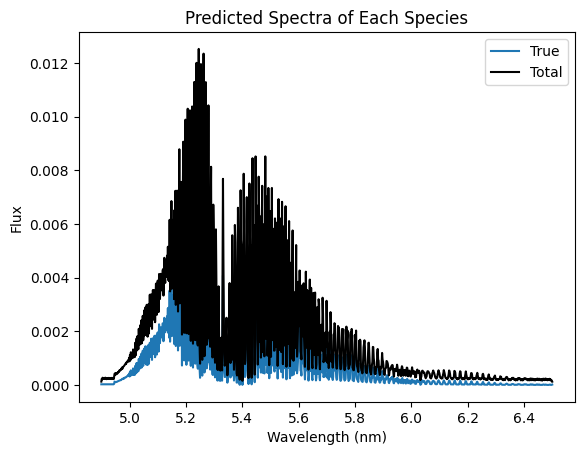

 10%|█         | 1/10 [00:00<00:01,  5.96it/s]

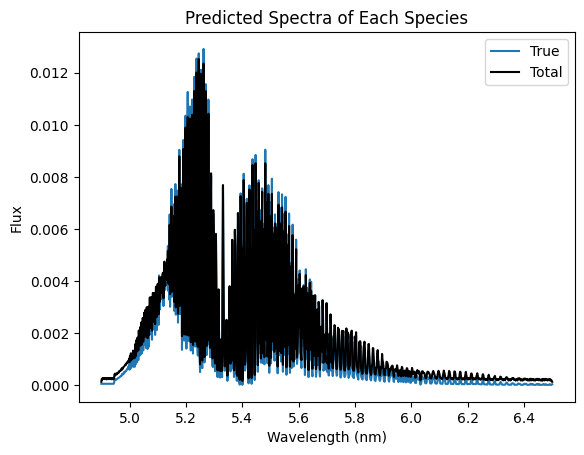

 20%|██        | 2/10 [00:00<00:01,  7.23it/s]

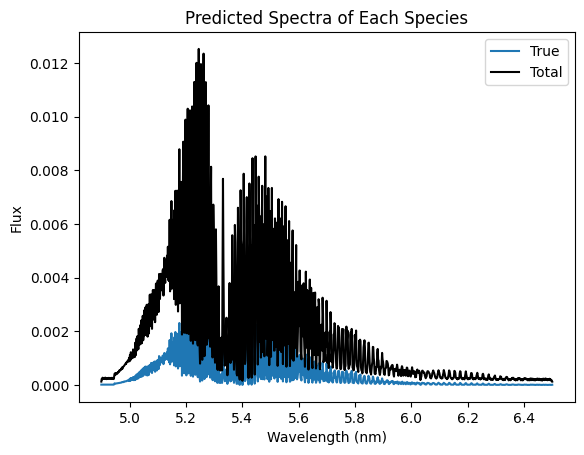

 30%|███       | 3/10 [00:00<00:00,  7.17it/s]

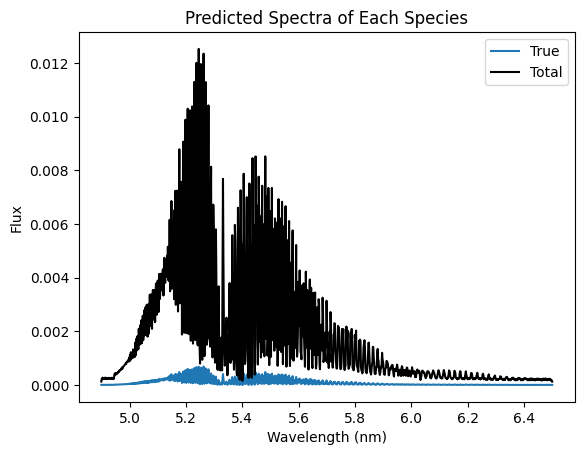

 40%|████      | 4/10 [00:00<00:00,  7.70it/s]

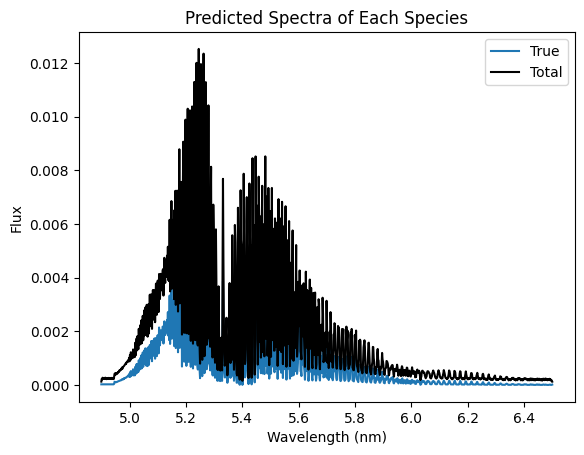

 50%|█████     | 5/10 [00:00<00:00,  8.04it/s]

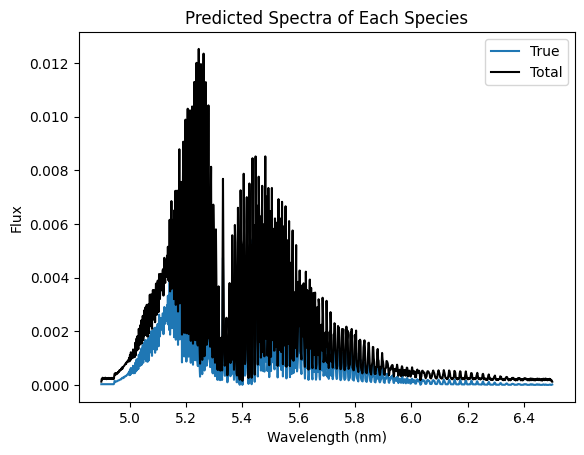

 60%|██████    | 6/10 [00:00<00:00,  7.90it/s]

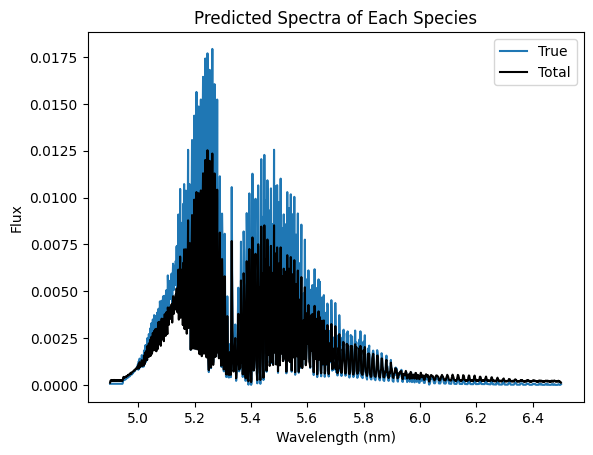

 70%|███████   | 7/10 [00:00<00:00,  7.85it/s]

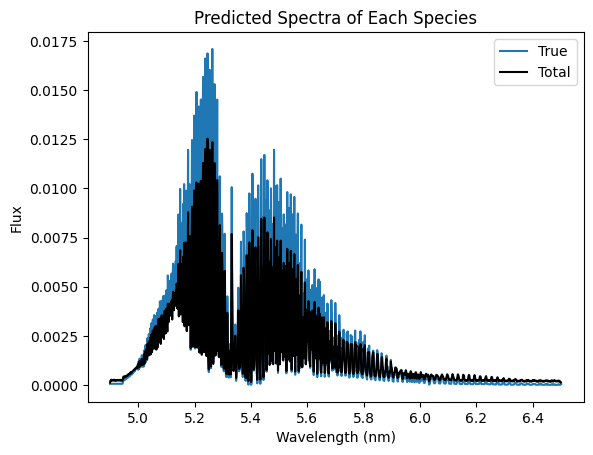

 80%|████████  | 8/10 [00:01<00:00,  7.75it/s]

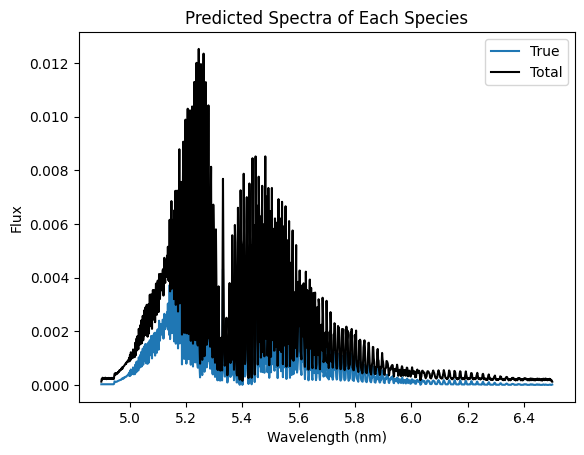

 90%|█████████ | 9/10 [00:01<00:00,  7.92it/s]

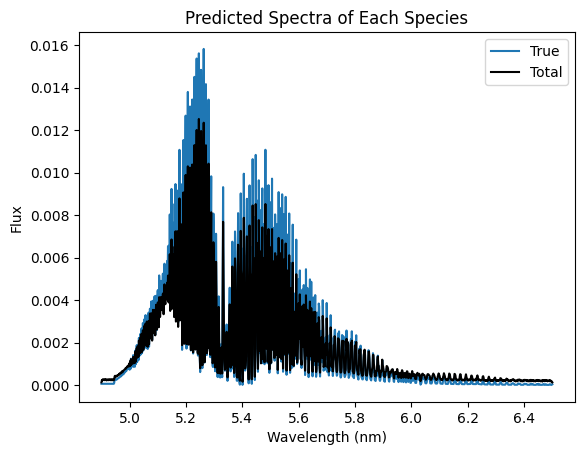

100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


In [237]:
for num in tqdm(range(10)):
    x = X[num]  # shape: (10000,)
    x = torch.tensor(x).unsqueeze(0).float()  # (1, 10000)
    Y = torch.tensor(y[num]).squeeze(0).float()   # shape: (11, 10000)

    # Sum over species to reconstruct the mixed signal
    y_reconstructed = Y
    model.eval()
    with torch.inference_mode():
        output = model(x)  # (1, 11, 10000)

    # Plot individual species' contributions
    # import matplotlib.pyplot as plt
    total = np.zeros(len((output[0, 0].numpy())))
    for i in range(1):
        total += output[0, 0].numpy()
        # plt.plot(total_wl, output[0, i].numpy(), label=f"{species[8]}")
    # plt.plot(total_wl, total, label="Total", color='black')
    plt.plot(total_wl, y_reconstructed, label='True')
    plt.plot(total_wl, total, label="Total", color='black')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux')
    # plt.xlim(5, 5.6)
    plt.legend()
    plt.title("Predicted Spectra of Each Species")
    # plt.ylim(0,0.005)
    plt.show()

In [105]:
with open('FLiTsData1000.pkl', 'rb') as f:
    df = pickle.load(f)

In [106]:
X_new = []
y_new = []
for i, row in tqdm(df.iterrows()):
    if i in [10, 15, 16, 20, 21, 22]:
        continue
    wl = row['FLiTs Wavelength']
    NH3_wl = row['FLiTs NO Wavelength']
    NH3_flux = np.interp(total_wl, NH3_wl, row['FLiTs NO Flux'])
    flux = np.interp(total_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
    flux_cont = np.interp(total_wl, wl, row['FLiTs Flux Continuum'])
    flux = add_noise(flux, SNR=300)-flux_cont + NH3_flux
    X_new.append(flux)
    y_new.append(NH3_flux)

X_new = np.array(X_new)
y_new = np.array(y_new)

25it [00:00, 210.52it/s]


Real AUC: 0.0011449742591447159 | CNN AUC: 0.0002541576300536067


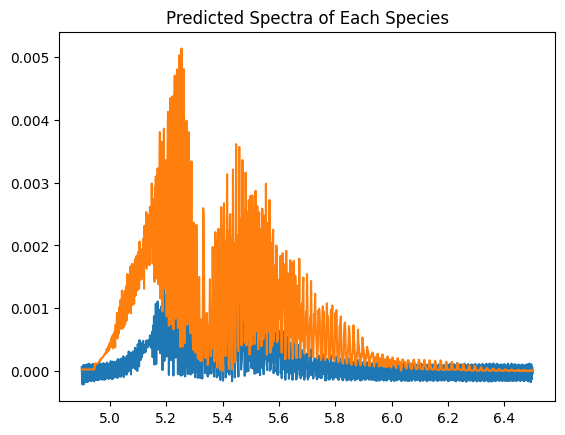

Real AUC: 0.0018742200447930452 | CNN AUC: 0.0002541576300536067


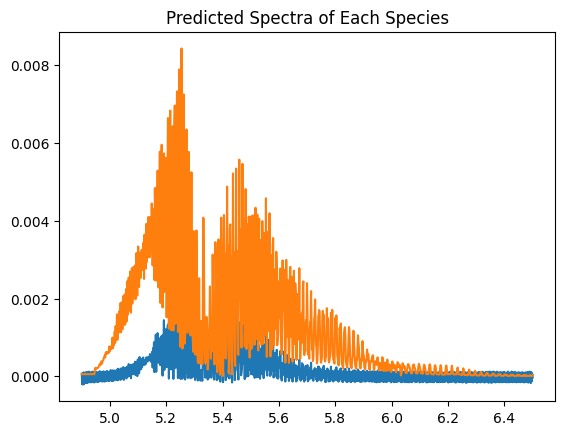

Real AUC: 0.0028107794698180896 | CNN AUC: 0.0002541576300536067


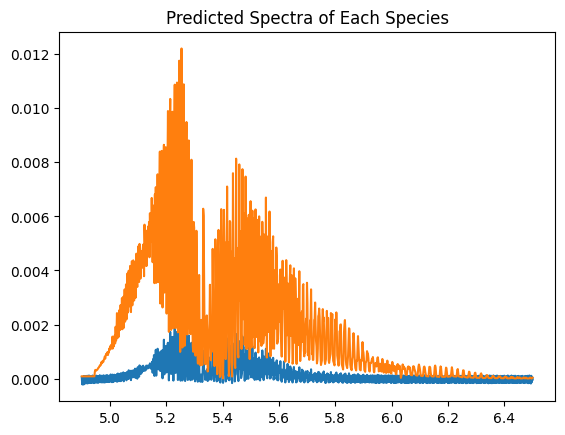

Real AUC: 0.0038644269497494768 | CNN AUC: 0.0002541576300536067


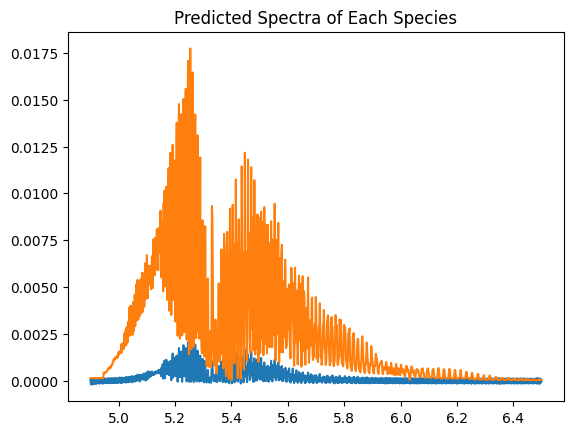

Real AUC: 0.005112842721770847 | CNN AUC: 0.0002541576300536067


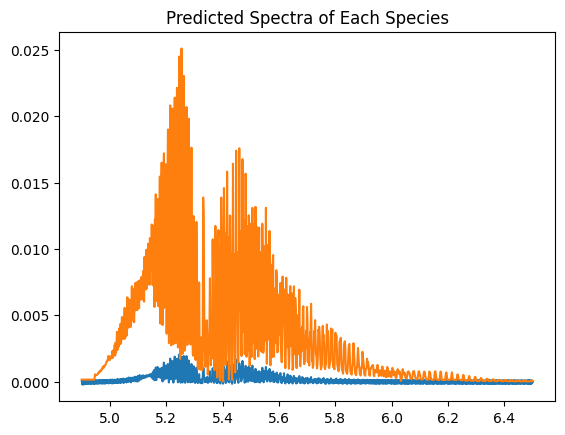

Real AUC: 0.0005294461597050216 | CNN AUC: 0.0002541576300536067


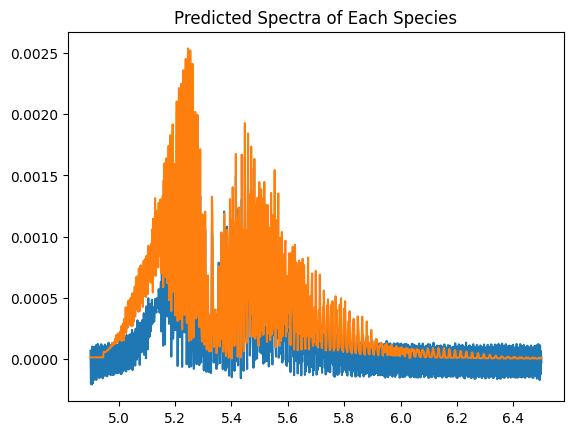

Real AUC: 0.0012514041478606797 | CNN AUC: 0.0002541576300536067


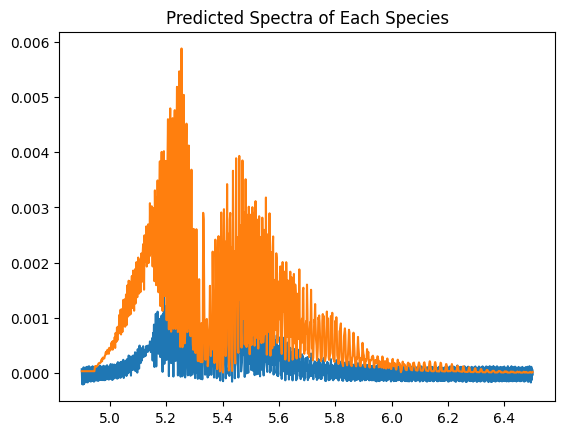

Real AUC: 0.002038889348829142 | CNN AUC: 0.0002541576300536067


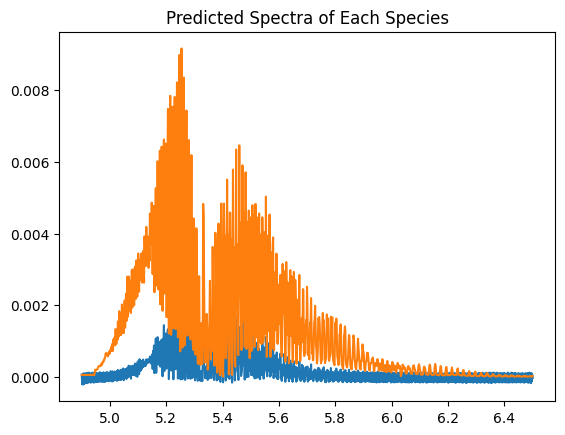

Real AUC: 0.002988932521983087 | CNN AUC: 0.0002541576300536067


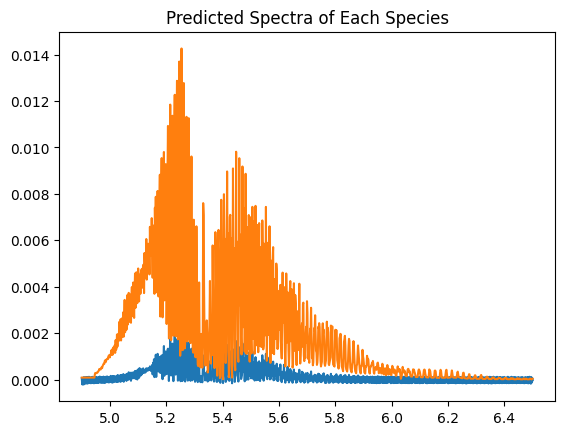

Real AUC: 0.004142879561203004 | CNN AUC: 0.0002541576300536067


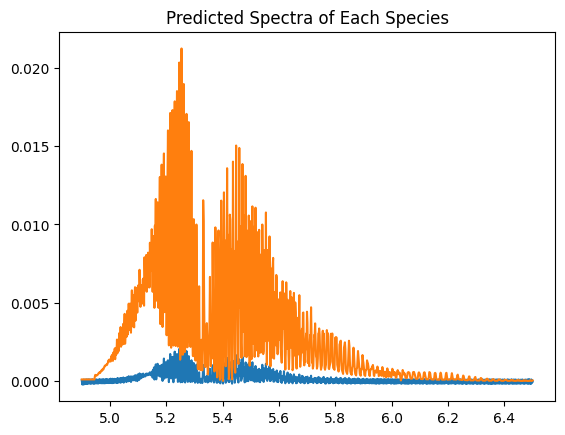

Real AUC: 0.00047620767942268286 | CNN AUC: 0.0002541576300536067


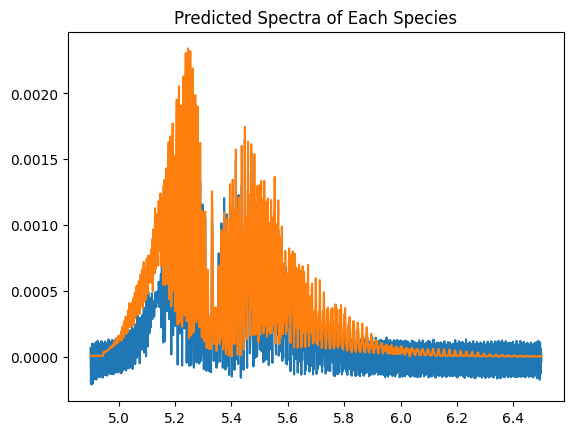

Real AUC: 0.0013061202841902135 | CNN AUC: 0.0002541576300536067


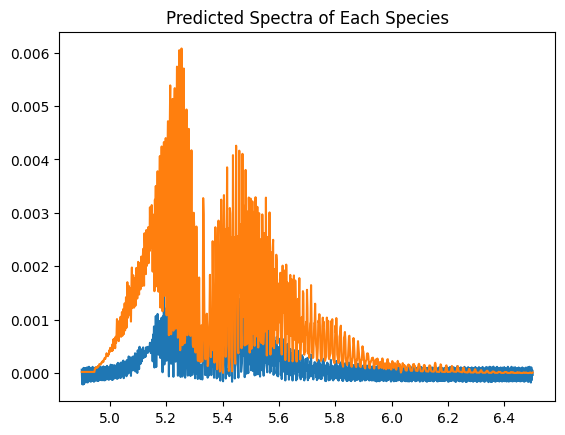

Real AUC: 0.002261492495247633 | CNN AUC: 0.0002541576300536067


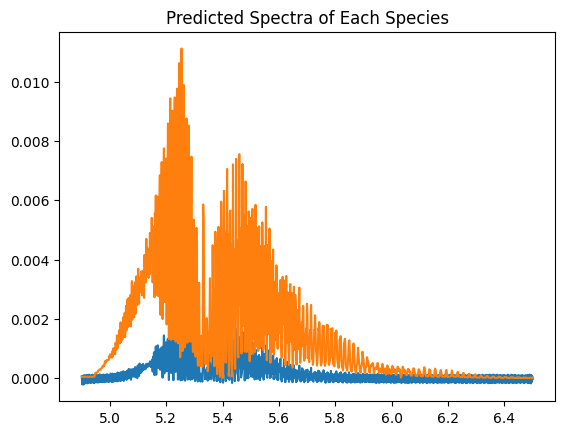

Real AUC: 0.003378237953711746 | CNN AUC: 0.0002541576300536067


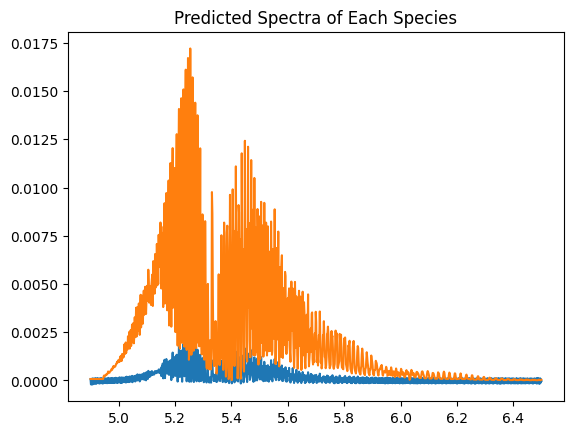

Real AUC: 0.0004860750709619383 | CNN AUC: 0.0002541576300536067


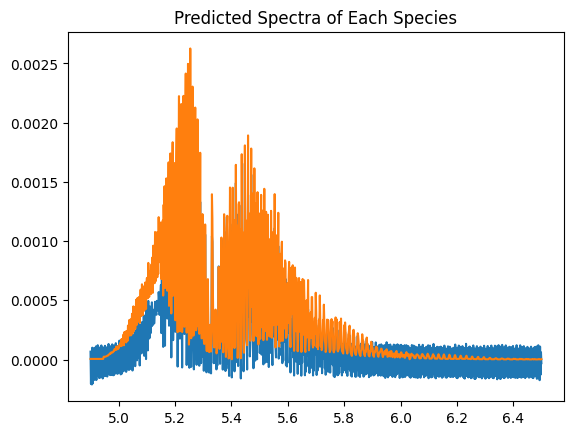

Real AUC: 0.001552376586532293 | CNN AUC: 0.0002541576300536067


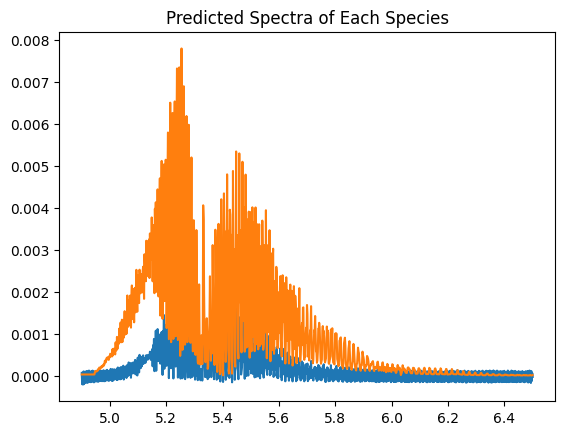

Real AUC: 0.002736325984952161 | CNN AUC: 0.0002541576300536067


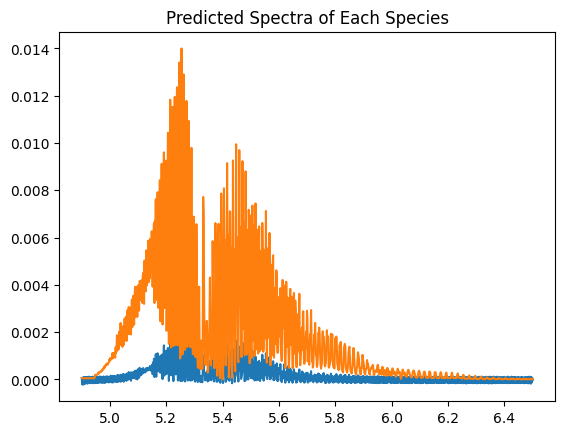

Real AUC: 0.000636273559453575 | CNN AUC: 0.0002541576300536067


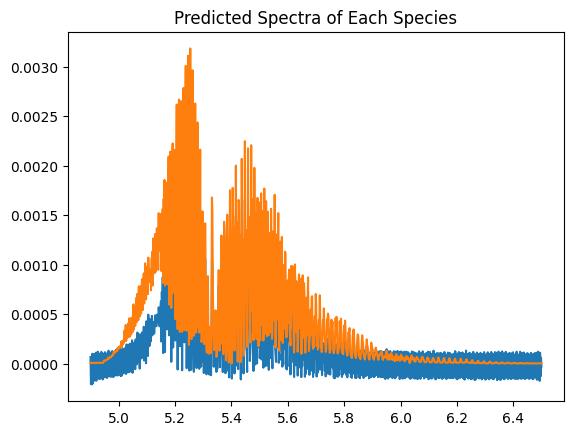

Real AUC: 0.0020656349288345455 | CNN AUC: 0.0002541576300536067


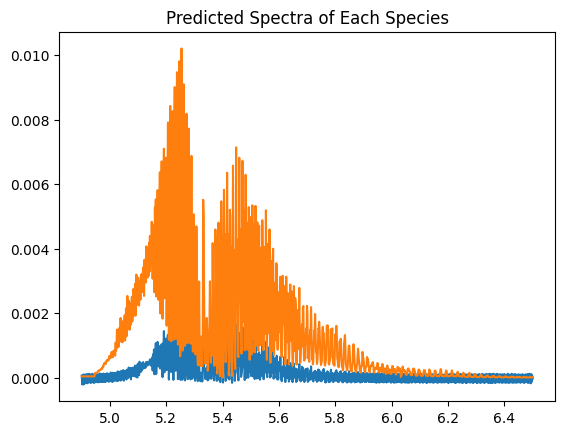

In [107]:
for i in range(19):
    x_new = X_new[i]  # shape: (10000,)
    x_new = torch.tensor(x_new).unsqueeze(0).float()
    with torch.inference_mode():
        output = model(x_new)
    # total_wl = np.linspace(4.9, 7, 1000)
    plt.plot(total_wl, output[0, 0].numpy())
    # plt.legend()
    plt.plot(total_wl, y_new[i])
    print(f'Real AUC: {np.trapezoid(y_new[i], total_wl)} | CNN AUC: {np.trapezoid(output[0, 0].numpy(), total_wl)}')
    plt.title("Predicted Spectra of Each Species")
    # plt.xlim(4.8, 6)
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [71]:
class SpectralRegressionCNN(nn.Module):
    def __init__(self, input_length=1000, n_outputs=11):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_outputs)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, input_length)
        return self.net(x)

In [32]:
species = ['NO']
X = []
y = []
total_wl = np.linspace(4.9, 6.5, 1000)
for i, row in tqdm(df.iterrows()):
    if i in [10, 15, 16, 20, 21, 22]:
        continue
    for _ in range(400):
        wl = row['FLiTs Wavelength']
        NH3_wl = row['FLiTs NH3 Wavelength']
        NH3_flux = np.interp(total_wl, NH3_wl, row['FLiTs NH3 Flux'])
        flux = np.interp(total_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
        flux_cont = np.interp(total_wl, wl, row['FLiTs Flux Continuum'])
        flux = add_noise(flux, SNR=300)-flux_cont + NH3_flux
        dat = []
        for specie in species:
            specie_wl = row[f'FLiTs {specie} Wavelength']
            specie_flux = row[f'FLiTs {specie} Flux']
            specie_flux = np.interp(total_wl, specie_wl, specie_flux)
            flux -= specie_flux
            specie_flux = np.random.uniform(0, 2) * specie_flux
            # specie_flux += np.random.normal(0, abs(np.mean(specie_flux)), len(specie_flux))
            flux += specie_flux
            dat.append(np.trapezoid(specie_flux, total_wl))
        X.append(flux)
        y.append(dat)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

25it [00:16,  1.51it/s]


In [72]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

model = SpectralRegressionCNN(input_length=1000, n_outputs=len(species))

In [19]:
model = torch.compile(model)

In [73]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

num_epochs = 3
print_interval = 100
for epoch in tqdm(range(num_epochs)):
    model.train()
    # if epoch % 10 == 0:
    #     learning_rate = 1e-4 * 0.9 ** (epoch//10)
    #     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epoch_loss = 0.0  # To track total loss for the current epoch
    for batch_idx, (xb, yb) in enumerate(dataloader):
        optimizer.zero_grad()

        # Forward pass
        pred = model(xb)

        # Compute loss
        loss = loss_fn(pred, yb)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track the loss for the epoch
        epoch_loss += loss.item()

        # Print the loss at specified intervals
        if (batch_idx + 1) % print_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.2e}")
            # pass

    # Print average loss for the entire epoch
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_epoch_loss:.2e}")

  0%|          | 0/3 [00:01<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x16000 and 128x64)

100%|██████████| 100/100 [00:00<00:00, 449.72it/s]


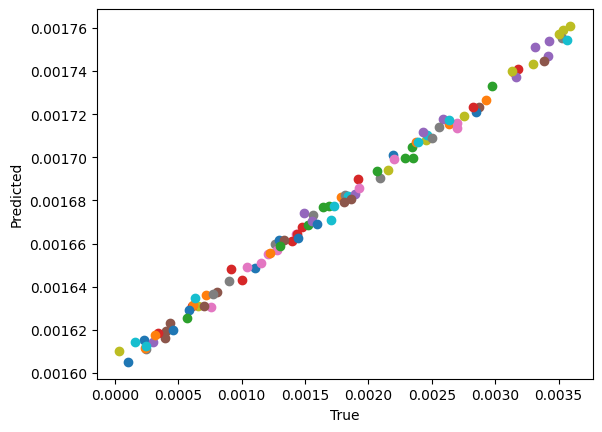

In [58]:
for num in tqdm(range(100)):
    x = X[num]  # shape: (10000,)
    x = torch.tensor(x).unsqueeze(0).float()  # (1, 10000)
    Y = torch.tensor(y[num]).squeeze(0).float()   # shape: (11, 10000)

    # Sum over species to reconstruct the mixed signal
    y_reconstructed = Y
    model.eval()
    with torch.inference_mode():
        output = model(x)
    plt.scatter(y_reconstructed, output)
# plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet1D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        # Encoder (Down)
        self.enc1 = self.conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool1d(2)

        self.enc2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool1d(2)

        self.enc3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool1d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder (Up)
        self.up3 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)

        self.up2 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)

        self.up1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Final output layer
        self.final_conv = nn.Conv1d(64, out_channels, kernel_size=1)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv1d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final_conv(d1)


In [123]:
model = UNet1D()
input_tensor = torch.randn(8, 1, 1000)  # batch size 8
output = model(input_tensor)
print(output.shape)

torch.Size([8, 1, 1000])


In [135]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

num_epochs = 300
print_interval = 100
for epoch in tqdm(range(num_epochs)):
    model.train()
    if epoch % 10 == 0:
        learning_rate = 1e-4 * 0.9 ** (epoch//10)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epoch_loss = 0.0  # To track total loss for the current epoch
    for batch_idx, (xb, yb) in enumerate(dataloader):
        optimizer.zero_grad()

        # Forward pass
        pred = model(xb.unsqueeze(1))

        # Compute loss
        loss = loss_fn(pred, yb)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track the loss for the epoch
        epoch_loss += loss.item()

        # Print the loss at specified intervals
        if (batch_idx + 1) % print_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.2e}")
            # pass

    # Print average loss for the entire epoch
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_epoch_loss:.2e}")

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [1/300], Batch [100/238], Loss: 3.22e-05
Epoch [1/300], Batch [200/238], Loss: 4.17e-05


  0%|          | 1/300 [01:41<8:26:40, 101.67s/it]

Epoch [1/300] completed. Average Loss: 8.06e-05
Epoch [2/300], Batch [100/238], Loss: 2.98e-05
Epoch [2/300], Batch [200/238], Loss: 2.36e-05


  1%|          | 2/300 [03:38<9:09:17, 110.60s/it]

Epoch [2/300] completed. Average Loss: 2.91e-05
Epoch [3/300], Batch [100/238], Loss: 2.34e-05
Epoch [3/300], Batch [200/238], Loss: 2.16e-05


  1%|          | 3/300 [05:35<9:22:16, 113.59s/it]

Epoch [3/300] completed. Average Loss: 2.25e-05
Epoch [4/300], Batch [100/238], Loss: 1.52e-05
Epoch [4/300], Batch [200/238], Loss: 1.75e-05


  1%|▏         | 4/300 [07:13<8:50:16, 107.49s/it]

Epoch [4/300] completed. Average Loss: 1.68e-05
Epoch [5/300], Batch [100/238], Loss: 1.88e-05
Epoch [5/300], Batch [200/238], Loss: 1.28e-05


  2%|▏         | 5/300 [09:09<9:03:43, 110.59s/it]

Epoch [5/300] completed. Average Loss: 1.43e-05
Epoch [6/300], Batch [100/238], Loss: 1.20e-05
Epoch [6/300], Batch [200/238], Loss: 1.66e-05


  2%|▏         | 6/300 [11:09<9:16:28, 113.57s/it]

Epoch [6/300] completed. Average Loss: 1.26e-05
Epoch [7/300], Batch [100/238], Loss: 9.96e-06
Epoch [7/300], Batch [200/238], Loss: 7.70e-06


  2%|▏         | 7/300 [13:04<9:17:15, 114.11s/it]

Epoch [7/300] completed. Average Loss: 1.11e-05
Epoch [8/300], Batch [100/238], Loss: 7.65e-06
Epoch [8/300], Batch [200/238], Loss: 7.65e-06


  3%|▎         | 8/300 [14:38<8:43:50, 107.64s/it]

Epoch [8/300] completed. Average Loss: 9.04e-06
Epoch [9/300], Batch [100/238], Loss: 6.28e-06
Epoch [9/300], Batch [200/238], Loss: 7.91e-06


  3%|▎         | 9/300 [16:24<8:39:33, 107.13s/it]

Epoch [9/300] completed. Average Loss: 8.54e-06
Epoch [10/300], Batch [100/238], Loss: 7.80e-06
Epoch [10/300], Batch [200/238], Loss: 6.81e-06


  3%|▎         | 10/300 [18:49<9:34:05, 118.78s/it]

Epoch [10/300] completed. Average Loss: 8.22e-06
Epoch [11/300], Batch [100/238], Loss: 8.71e-06
Epoch [11/300], Batch [200/238], Loss: 5.43e-06


  4%|▎         | 11/300 [21:01<9:52:08, 122.94s/it]

Epoch [11/300] completed. Average Loss: 2.16e-05
Epoch [12/300], Batch [100/238], Loss: 5.26e-06
Epoch [12/300], Batch [200/238], Loss: 1.26e-05


  4%|▍         | 12/300 [23:05<9:52:20, 123.40s/it]

Epoch [12/300] completed. Average Loss: 6.20e-06
Epoch [13/300], Batch [100/238], Loss: 5.40e-06
Epoch [13/300], Batch [200/238], Loss: 4.99e-06


  4%|▍         | 13/300 [25:17<10:02:24, 125.94s/it]

Epoch [13/300] completed. Average Loss: 5.90e-06
Epoch [14/300], Batch [100/238], Loss: 6.60e-06
Epoch [14/300], Batch [200/238], Loss: 4.21e-06


  5%|▍         | 14/300 [27:00<9:26:56, 118.94s/it] 

Epoch [14/300] completed. Average Loss: 5.73e-06
Epoch [15/300], Batch [100/238], Loss: 6.13e-06
Epoch [15/300], Batch [200/238], Loss: 4.35e-06


  5%|▌         | 15/300 [28:55<9:19:37, 117.82s/it]

Epoch [15/300] completed. Average Loss: 6.05e-06
Epoch [16/300], Batch [100/238], Loss: 3.68e-06
Epoch [16/300], Batch [200/238], Loss: 4.03e-06


  5%|▌         | 15/300 [31:11<9:52:45, 124.79s/it]


KeyboardInterrupt: 

  0%|          | 0/10 [00:00<?, ?it/s]

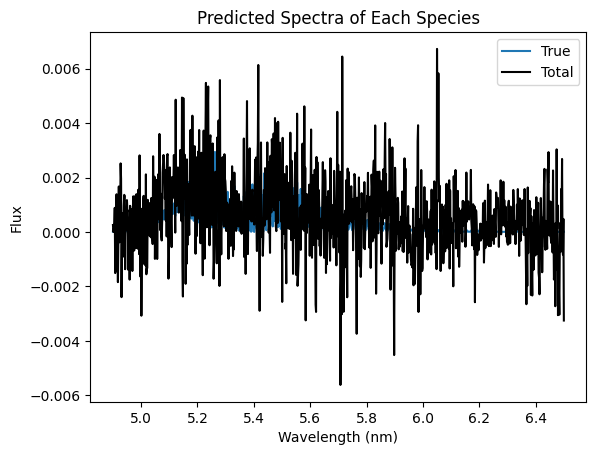

 10%|█         | 1/10 [00:00<00:01,  6.35it/s]

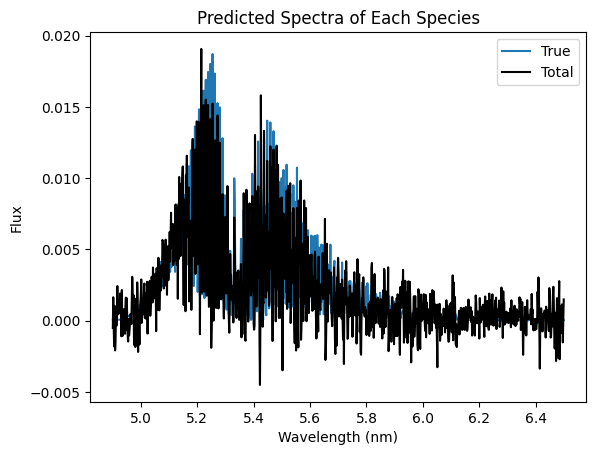

 20%|██        | 2/10 [00:00<00:01,  6.94it/s]

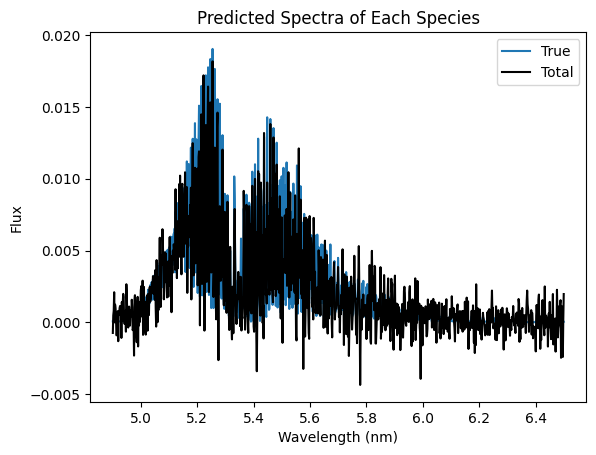

 30%|███       | 3/10 [00:00<00:00,  7.13it/s]

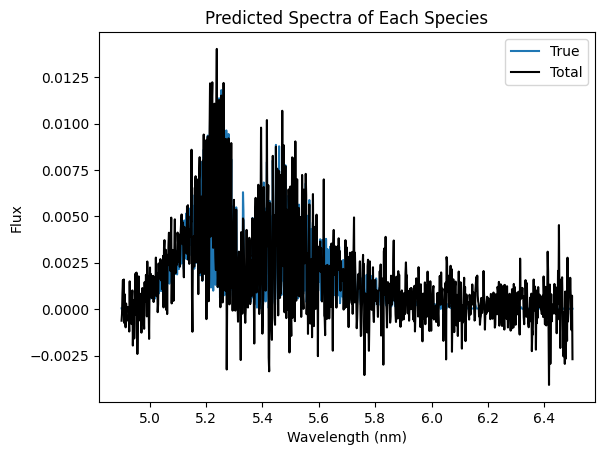

 40%|████      | 4/10 [00:00<00:00,  7.50it/s]

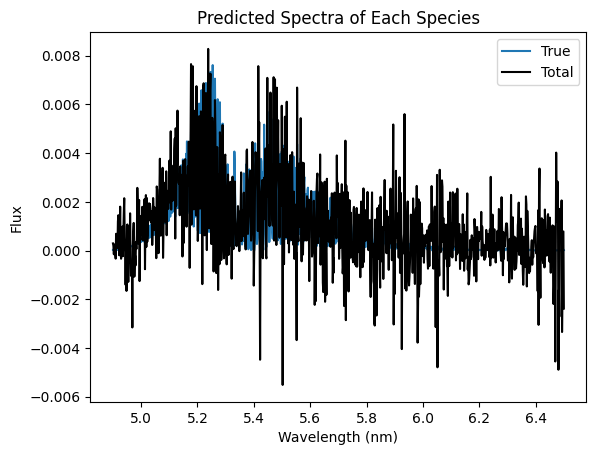

 50%|█████     | 5/10 [00:00<00:00,  7.50it/s]

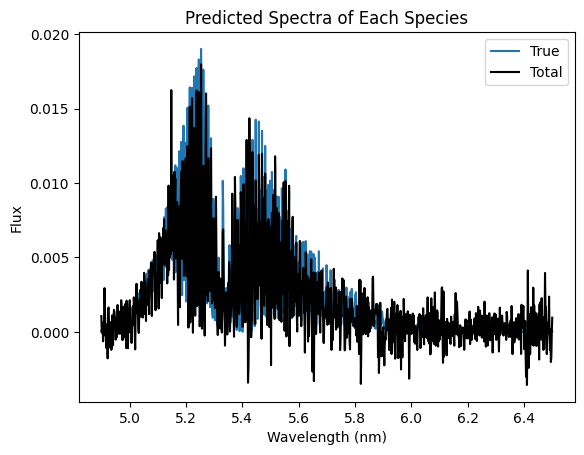

 60%|██████    | 6/10 [00:00<00:00,  7.78it/s]

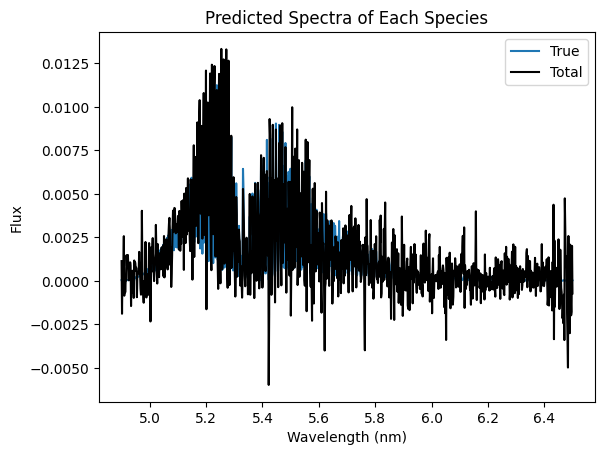

 70%|███████   | 7/10 [00:00<00:00,  7.76it/s]

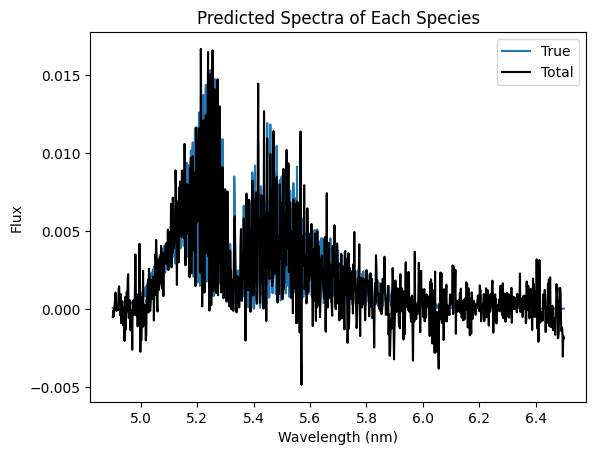

 80%|████████  | 8/10 [00:01<00:00,  8.13it/s]

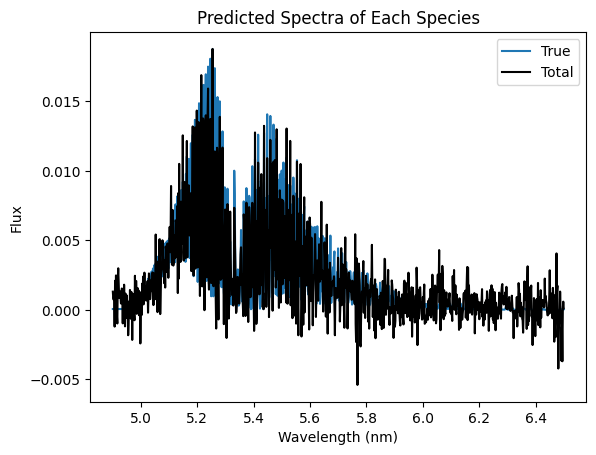

 90%|█████████ | 9/10 [00:01<00:00,  8.12it/s]

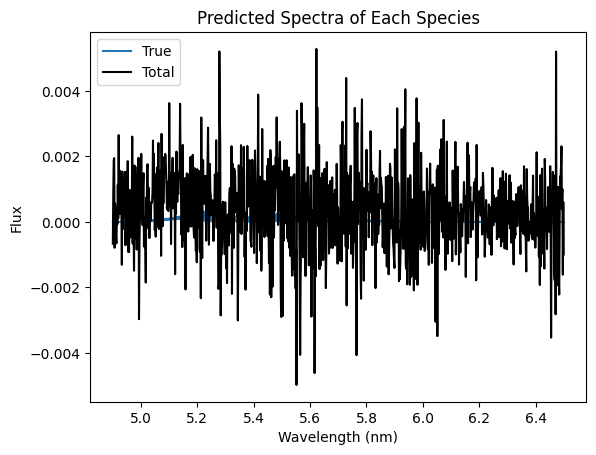

100%|██████████| 10/10 [00:01<00:00,  7.75it/s]


In [136]:
for num in tqdm(range(10)):
    x = X[num]  # shape: (10000,)
    x = torch.tensor(x).unsqueeze(0).float()  # (1, 10000)
    Y = torch.tensor(y[num]).squeeze(0).float()   # shape: (11, 10000)

    # Sum over species to reconstruct the mixed signal
    y_reconstructed = Y
    model.eval()
    with torch.inference_mode():
        output = model(x.unsqueeze(1))  # (1, 11, 10000)

    # Plot individual species' contributions
    # import matplotlib.pyplot as plt
    total = np.zeros(len((output[0, 0].numpy())))
    for i in range(1):
        total += output[0, 0].numpy()
        # plt.plot(total_wl, output[0, i].numpy(), label=f"{species[8]}")
    # plt.plot(total_wl, total, label="Total", color='black')
    plt.plot(total_wl, y_reconstructed, label='True')
    plt.plot(total_wl, total, label="Total", color='black')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux')
    # plt.xlim(5, 5.6)
    plt.legend()
    plt.title("Predicted Spectra of Each Species")
    # plt.ylim(0,0.005)
    plt.show()

# Layout Thesis

**Front Page**
- Title
- Name
- student id
- supervisors
- daily supervisors
- 2nd corrector

**Abstract**
- Summary of thesis

**Table of Contents**

**Introduction**
- History
- Papers with observations of different molecules
- Objective (detecting molecules that haven't been detected)
- Shape of the thesis (Explaining what is discussed in each chapter

**Theoretical Background**
- General introduction to protoplanetary disks (formation, evolution, etc.)
- Modeling (ProDiMo + FLiTs)
- General theory behind methods

**Methods**
- Explanation of Simulations ran (Parameters)
- Further methods

**Results**
- Results from the methods

**Discussion**
- Comparing to others
- Possible improvements

**Conclusion**
- Summarizing the thesis

25it [00:01, 19.38it/s]


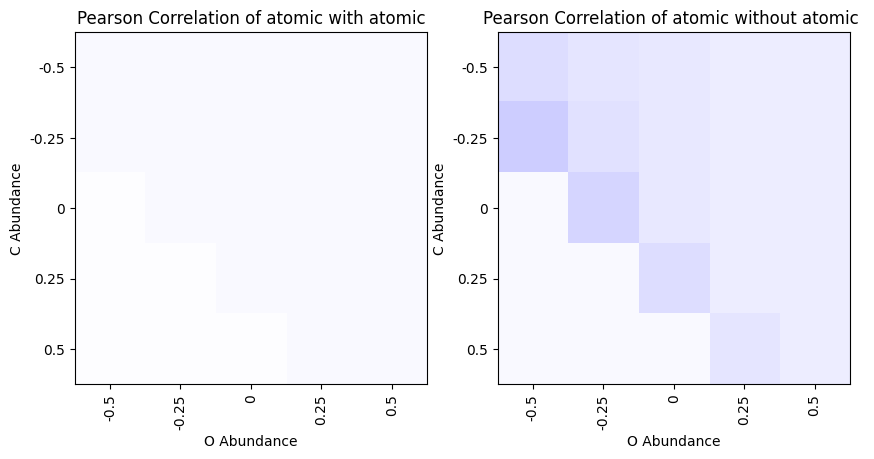

25it [00:01, 22.06it/s]


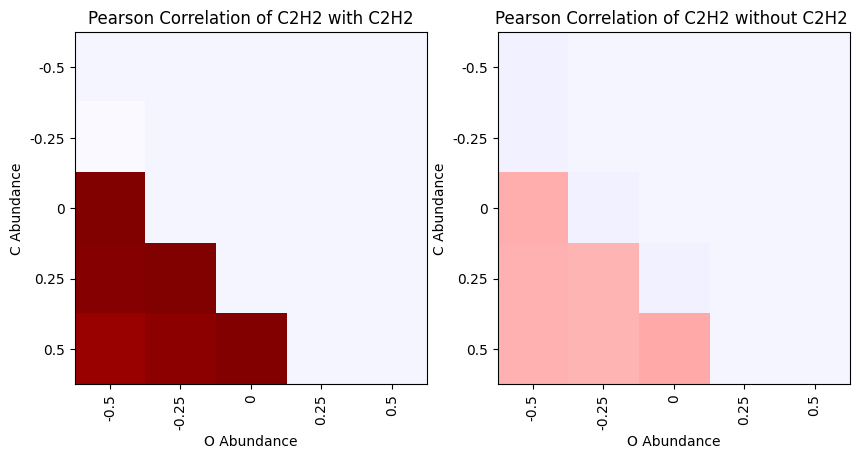

25it [00:01, 20.92it/s]


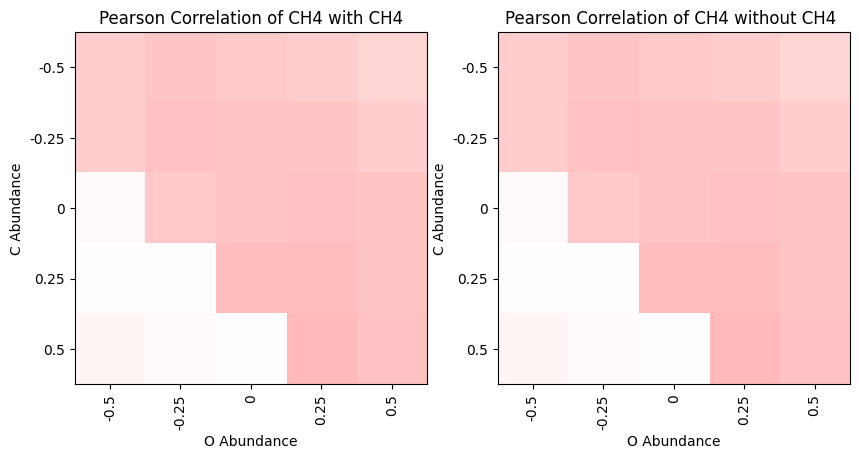

25it [00:01, 23.93it/s]


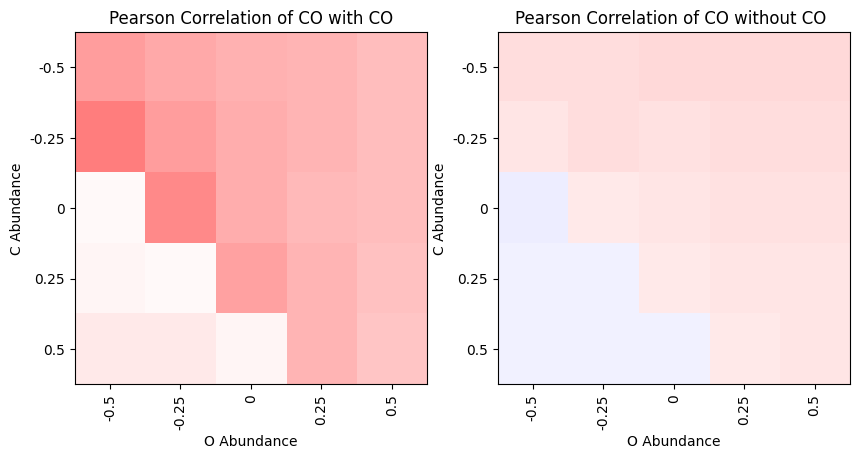

25it [00:01, 23.76it/s]


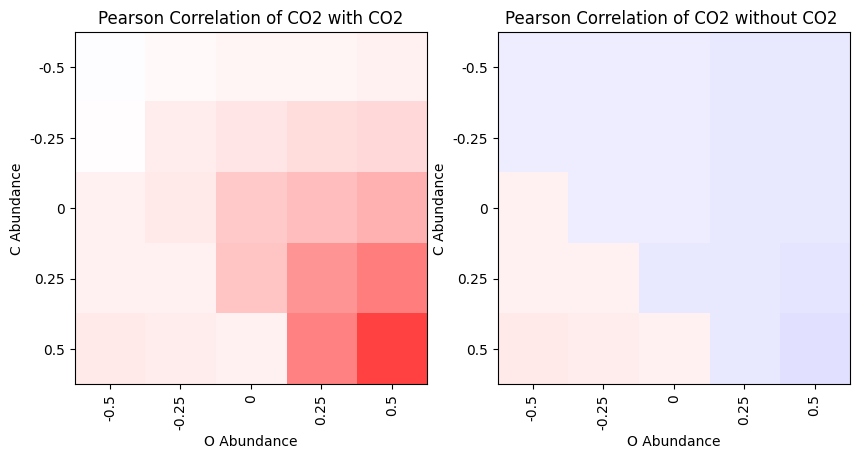

25it [00:01, 23.88it/s]


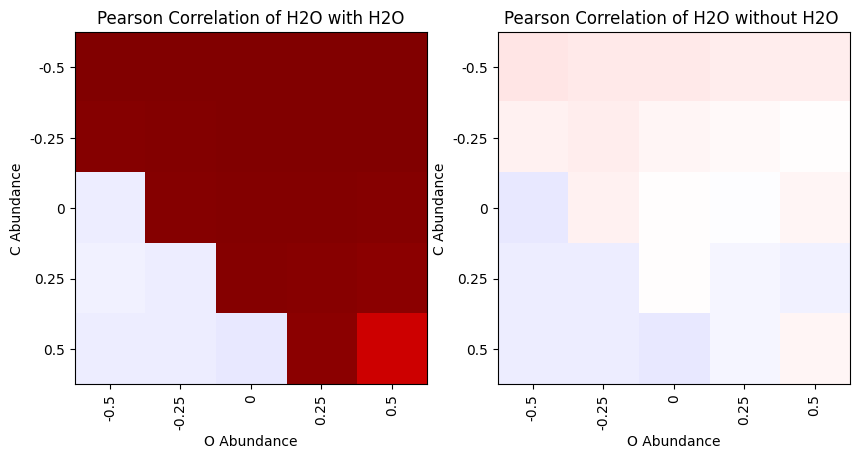

25it [00:01, 23.88it/s]


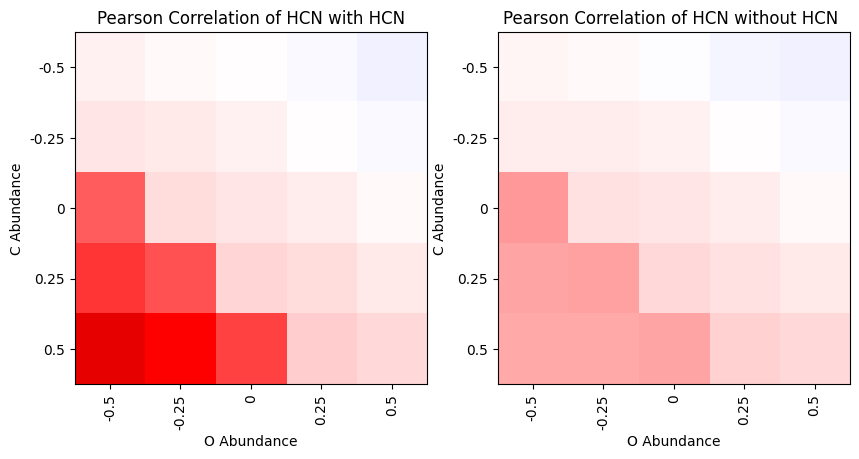

25it [00:01, 23.69it/s]


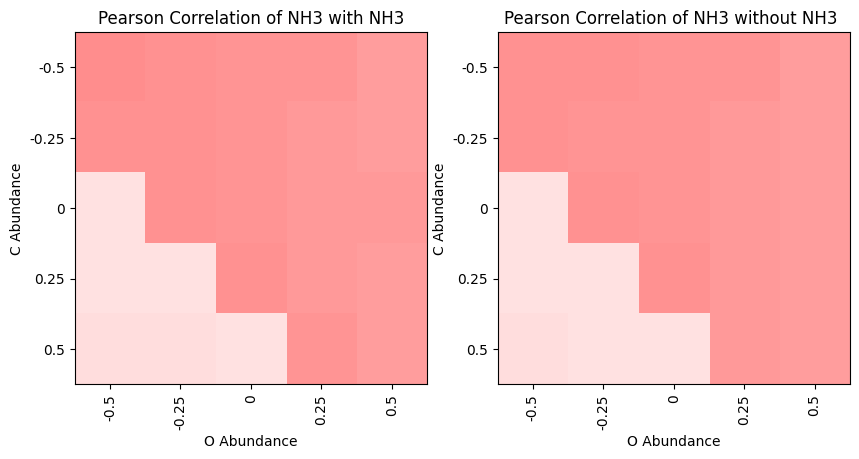

25it [00:01, 24.28it/s]


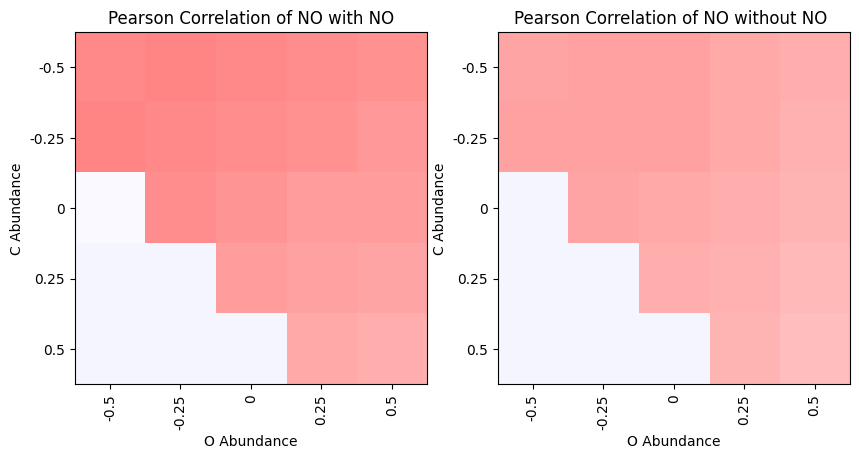

9it [00:00, 24.85it/s]C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_23192\4074343881.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr.append(pearsonr(flux, specie_flux)[0])
C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_23192\4074343881.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr_without.append(pearsonr(flux-specie_flux, specie_flux)[0])
25it [00:01, 23.94it/s]


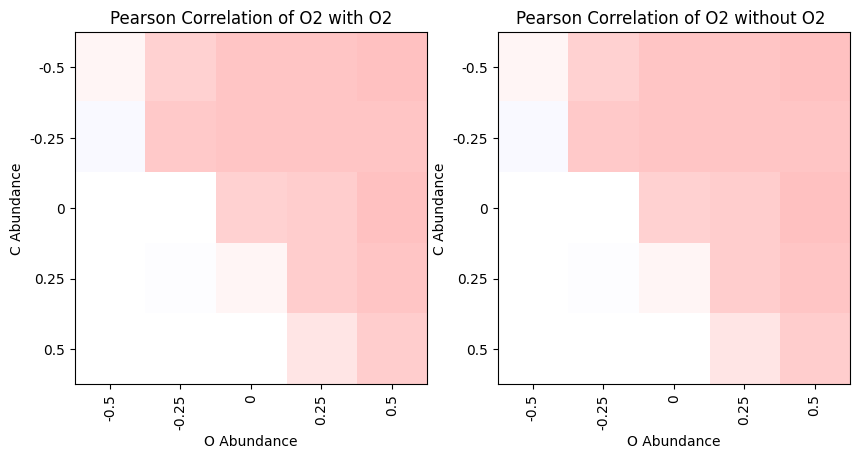

25it [00:01, 24.31it/s]


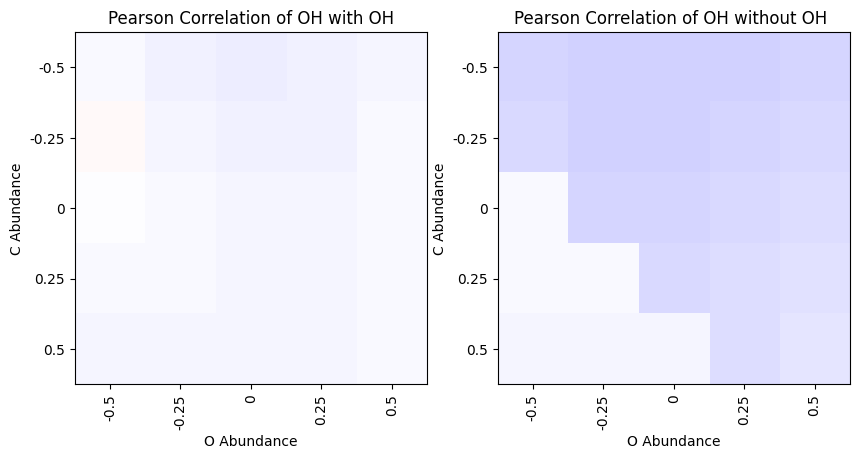

In [11]:
for specie in ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']:
    pearson_corr = []
    pearson_corr_without = []
    for i, row in tqdm(df.iterrows()):
        # if i in [10, 15, 16, 20, 21, 22]:
        #     continue
        wl = row['FLiTs Wavelength']
        NH3_wl = row['FLiTs NH3 Wavelength']
        NH3_flux = row['FLiTs NH3 Flux']
        flux = np.interp(NH3_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
        flux_cont = np.interp(NH3_wl, wl, row['FLiTs Flux Continuum'])
        flux = add_noise(flux, SNR=30000)-flux_cont + NH3_flux
        specie_wl = row[f'FLiTs {specie} Wavelength']
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_flux = np.interp(NH3_wl, specie_wl, specie_flux)
        pearson_corr.append(pearsonr(flux, specie_flux)[0])
        pearson_corr_without.append(pearsonr(flux-specie_flux, specie_flux)[0])
    pearson_corr = np.array(pearson_corr)
    pearson_corr_without = np.array(pearson_corr_without)
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].imshow(pearson_corr.reshape(5,5), cmap='seismic',  vmin=-1, vmax=1)
    ax[1].imshow(pearson_corr_without.reshape(5,5), cmap='seismic',  vmin=-1, vmax=1)
    # ax[1].colorbar()
    ax[0].set_title(f"Pearson Correlation of {specie} with {specie}")
    ax[1].set_title(f"Pearson Correlation of {specie} without {specie} ")
    ax[0].set_xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    ax[0].set_yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    ax[1].set_xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    ax[1].set_yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    ax[0].set_xlabel('O Abundance')
    ax[0].set_ylabel('C Abundance')
    ax[1].set_xlabel('O Abundance')
    ax[1].set_ylabel('C Abundance')
    plt.show()

0it [00:00, ?it/s]

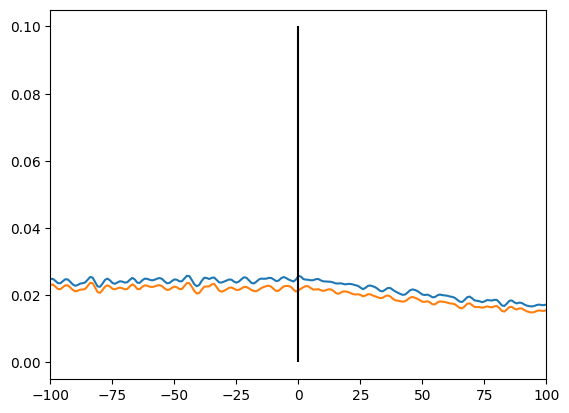

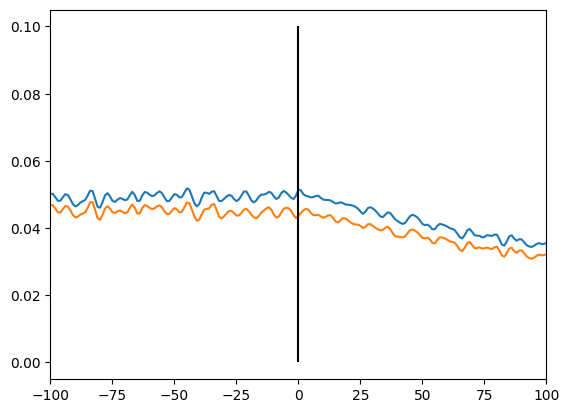

2it [00:00, 14.91it/s]

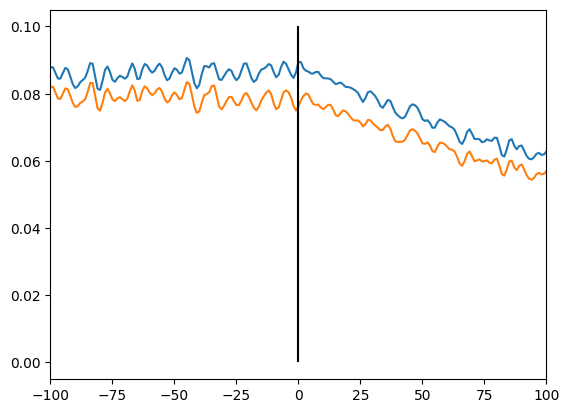

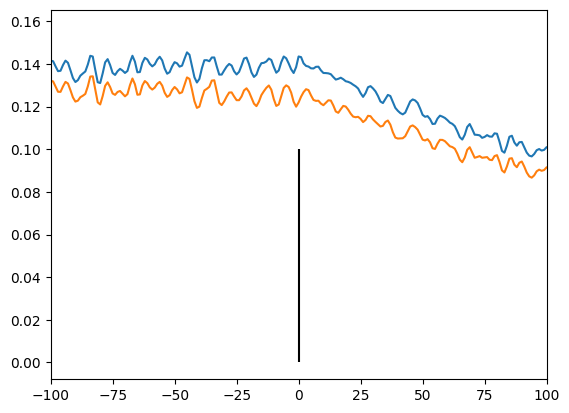

4it [00:00, 14.22it/s]

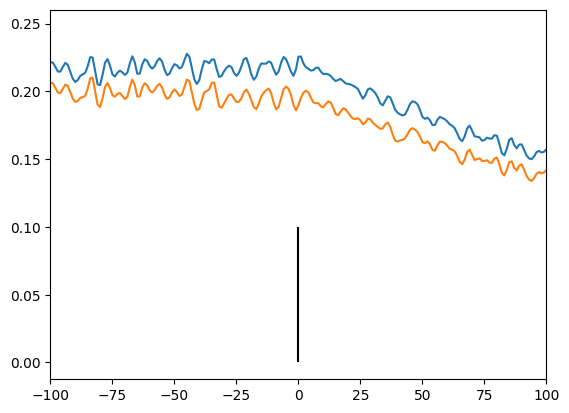

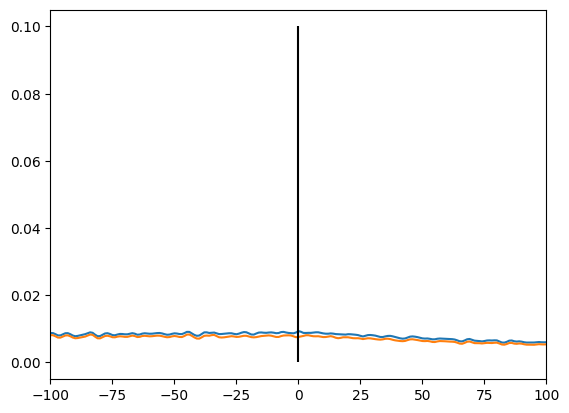

6it [00:00, 14.46it/s]

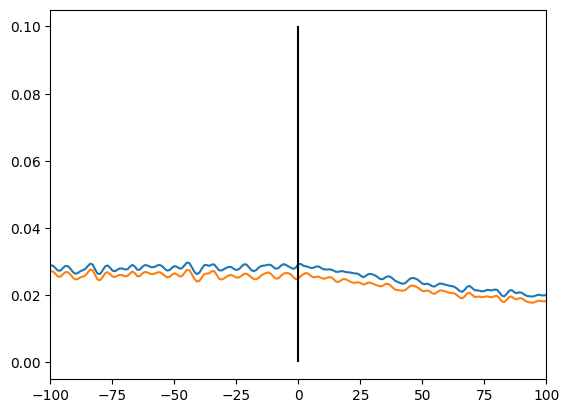

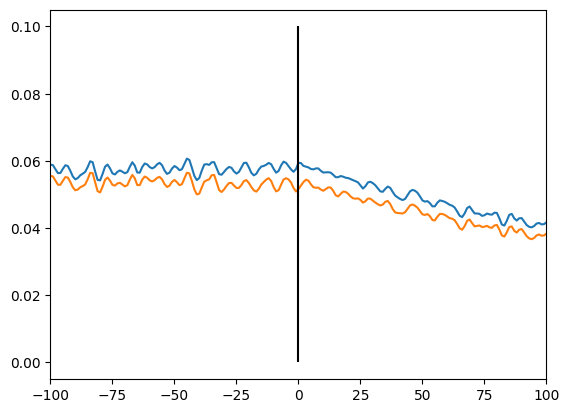

8it [00:00, 14.80it/s]

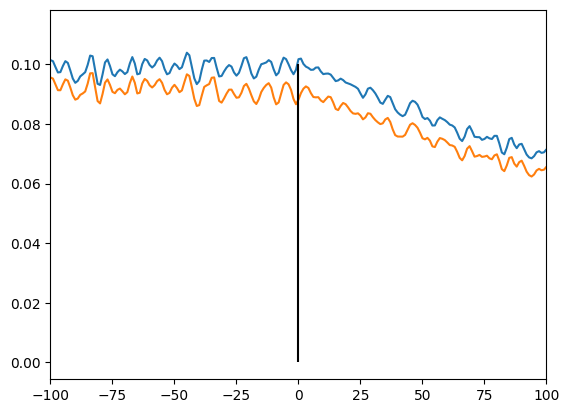

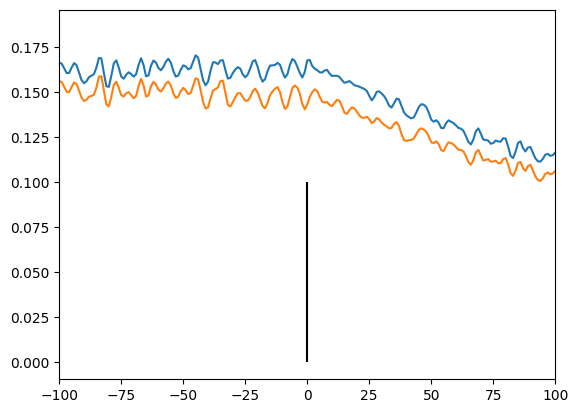

10it [00:00, 14.43it/s]

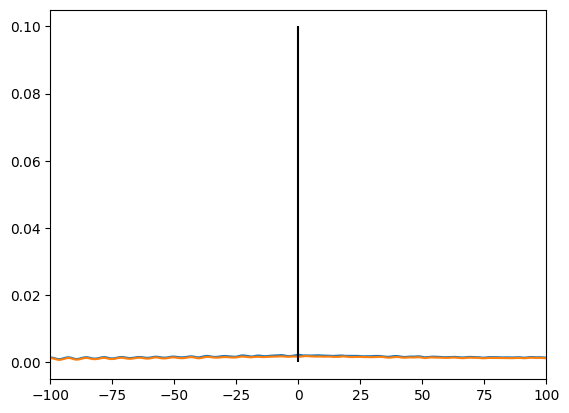

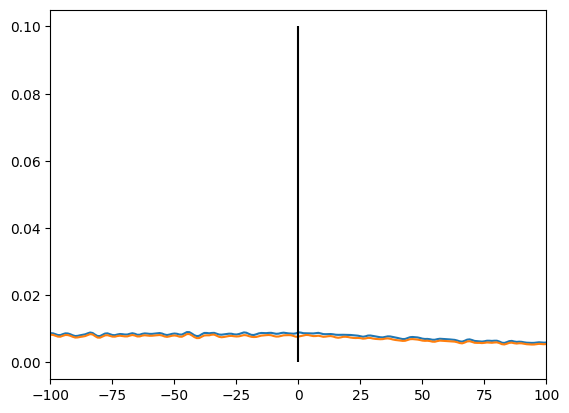

12it [00:00, 14.74it/s]

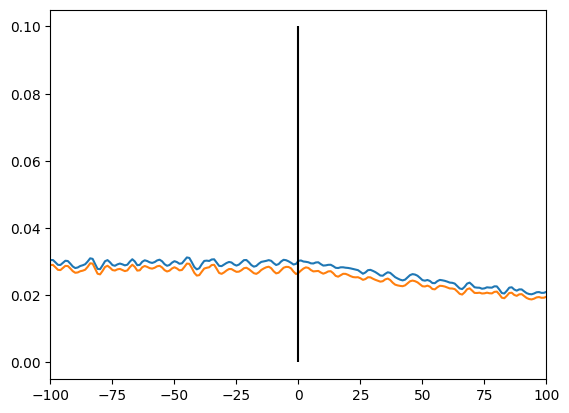

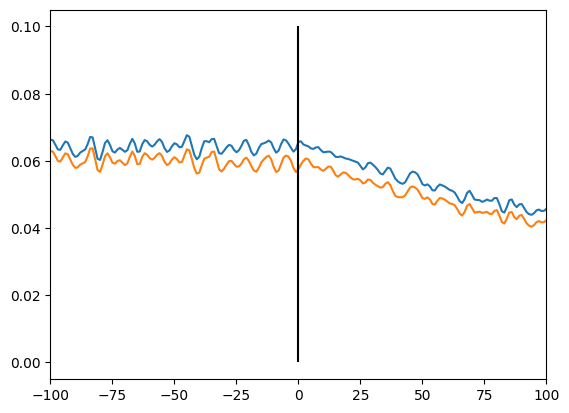

14it [00:00, 14.89it/s]

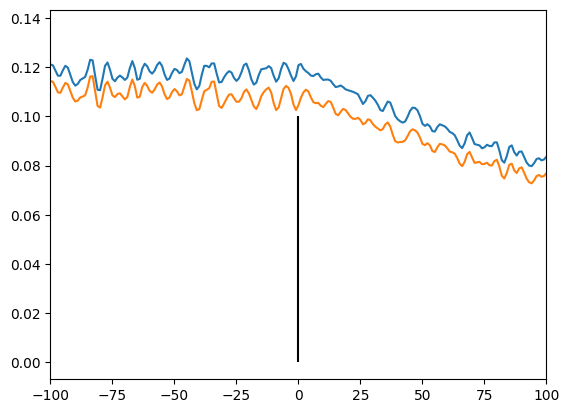

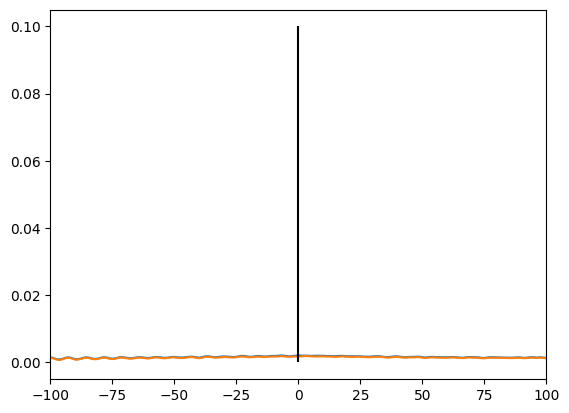

16it [00:01, 14.67it/s]

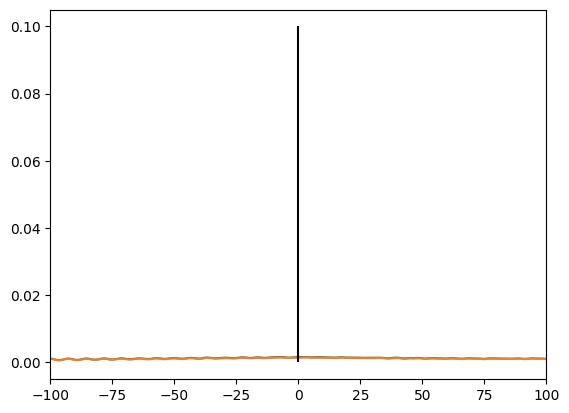

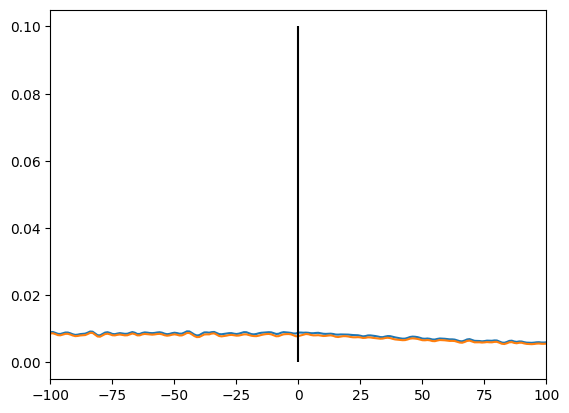

18it [00:01, 14.38it/s]

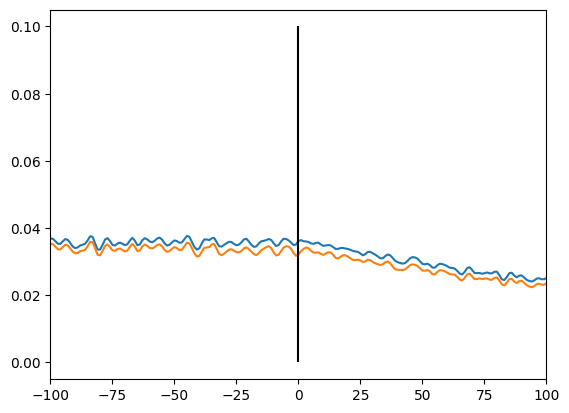

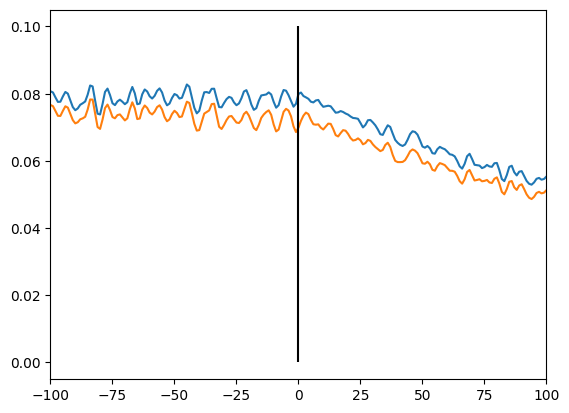

20it [00:01, 14.46it/s]

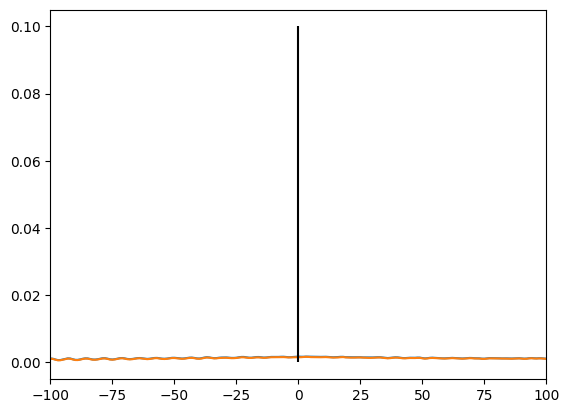

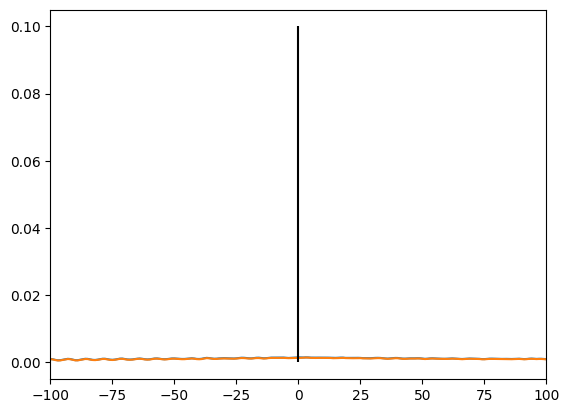

22it [00:01, 14.01it/s]

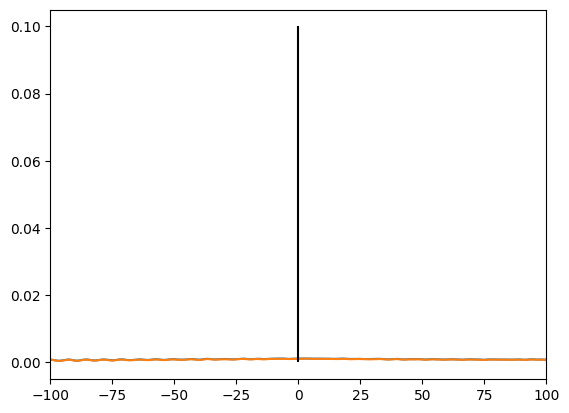

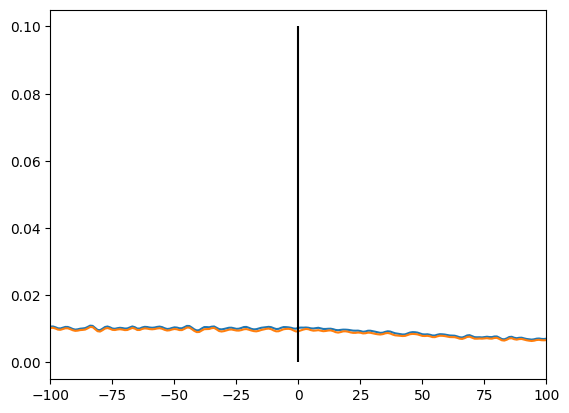

24it [00:01, 14.11it/s]

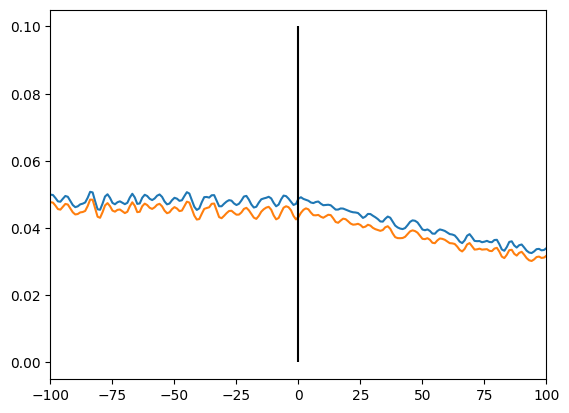

25it [00:01, 14.42it/s]


In [207]:
specie = 'NO'
for i, row in tqdm(df.iterrows()):
    wl = row['FLiTs Wavelength']
    NH3_wl_old = row['FLiTs NH3 Wavelength']
    NH3_wl = np.linspace(5.2, 6.3, 1000)
    NH3_flux = np.interp(NH3_wl, NH3_wl_old, row['FLiTs NH3 Flux'])
    flux = np.interp(NH3_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
    flux_cont = np.interp(NH3_wl, wl, row['FLiTs Flux Continuum'])
    flux = add_noise(flux, SNR=300)-flux_cont + NH3_flux
    specie_wl = row[f'FLiTs {specie} Wavelength']
    specie_flux = row[f'FLiTs {specie} Flux']
    specie_flux = np.interp(NH3_wl, specie_wl, specie_flux)
    flux = np.interp(NH3_wl, NH3_wl, flux)
    cc = fftconvolve((specie_flux), (flux)[::-1], mode='full')
    cc_without = fftconvolve((specie_flux), (flux-specie_flux)[::-1], mode='full')
    lags = np.arange(-len(specie_flux)+1, len(flux))
    plt.plot(lags, cc)
    plt.plot(lags, cc_without)
    plt.xlim(-100, 100)
    plt.vlines(0, 0, 0.1, color='black')
    plt.show()

In [17]:
specie = 'NH3'
def difference(params):
    a,b,c  = params
    total = 0
    for i, row in df.iterrows():
        if i not in [10, 15, 16, 20, 21, 22]:
            continue
        wl = row['FLiTs Wavelength']
        NH3_wl_old = row['FLiTs NH3 Wavelength']
        NH3_wl = np.linspace(5, 28, 100000)
        wl_mask = (NH3_wl < a) | (NH3_wl > b)
        NH3_flux = np.interp(NH3_wl, NH3_wl_old, row['FLiTs NH3 Flux'])
        flux = np.interp(NH3_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
        flux_cont = np.interp(NH3_wl, wl, row['FLiTs Flux Continuum'])
        flux = add_noise(flux, SNR=300)-flux_cont + NH3_flux
        specie_wl = row[f'FLiTs {specie} Wavelength']
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_flux = np.interp(NH3_wl, specie_wl, specie_flux)
        specie_flux[wl_mask] = 0
        flux[wl_mask] = 0
        flux[flux>c] = 0
        cc = fftconvolve((specie_flux), (flux)[::-1], mode='full')
        cc_without = fftconvolve((specie_flux), (flux-specie_flux)[::-1], mode='full')
        lags = np.arange(-len(specie_flux)+1, len(flux))
        total -= abs(cc[lags==0]-cc_without[lags==0])/abs(b-a+1)
    return total

initial_guess = [6, 6.4, 1]

result = minimize(difference, initial_guess, method='Nelder-Mead')

best_params = result.x
print(best_params)

[6.02622319 6.30250393 1.07902725]


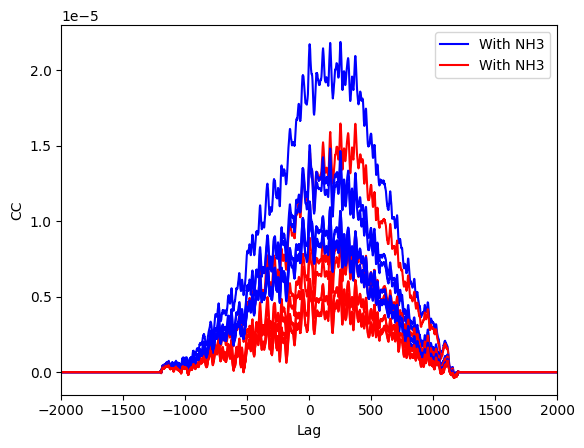

In [31]:
specie = 'NH3'
a,b, c = best_params
for i, row in df.iterrows():
    if i not in [10, 15, 16, 20, 21, 22]:
        continue
    wl = row['FLiTs Wavelength']
    NH3_wl_old = row['FLiTs NH3 Wavelength']
    NH3_wl = np.linspace(5, 28, 100000)
    wl_mask = (NH3_wl < a) | (NH3_wl > b)
    NH3_flux = np.interp(NH3_wl, NH3_wl_old, row['FLiTs NH3 Flux'])
    flux = np.interp(NH3_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
    flux_cont = np.interp(NH3_wl, wl, row['FLiTs Flux Continuum'])
    np.random.seed(0)
    flux = add_noise(flux, SNR=300)-flux_cont + NH3_flux
    specie_wl = row[f'FLiTs {specie} Wavelength']
    specie_flux = row[f'FLiTs {specie} Flux']
    specie_flux = np.interp(NH3_wl, specie_wl, specie_flux)
    specie_flux[wl_mask] = 0
    flux[wl_mask] = 0
    flux[flux>c] = 0
    cc = fftconvolve((specie_flux), (flux)[::-1], mode='full')
    cc_without = fftconvolve((specie_flux), (flux-specie_flux)[::-1], mode='full')
    lags = np.arange(-len(specie_flux)+1, len(flux))
    plt.plot(lags, cc, c='blue')
    plt.plot(lags, cc_without, c='red')
    plt.xlim(-2000, 2000)
    # plt.vlines(0, 0, 0.01, color='black')
plt.plot(lags, cc, c='blue', label='With NH3')
plt.plot(lags, cc_without, c='red', label='With NH3')
plt.legend(loc='upper right')
plt.xlabel('Lag')
plt.ylabel('CC')
plt.show()

In [6]:
class fluxNN(nn.Module):
    def __init__(self, n_input):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_input, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
    def forward(self, x):
        return self.layers(x)


In [8]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

In [34]:
X = []
y = []
total_wl = np.linspace(4.9, 27.5, 10675)
step_size = 0.1
for i, row in tqdm(df.iterrows()):
    for _ in range(400):
        wl = row['FLiTs Wavelength']
        NH3_wl = row['FLiTs NH3 Wavelength']
        NH3_flux = np.interp(total_wl, NH3_wl, row['FLiTs NH3 Flux'])
        NH3_flux *= np.random.uniform(0, 2)
        flux = np.interp(total_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
        flux_cont = np.interp(total_wl, wl, row['FLiTs Flux Continuum'])
        flux = add_noise(flux, SNR=300)-flux_cont + NH3_flux
        dat=[]
        for step in np.arange(4.9, 27.5, step_size):
            dat.append(calc_flux(total_wl, flux, [step, step+step_size]))
        X.append(dat)
        y.append(total_flux(total_wl, NH3_flux))
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

25it [01:58,  4.75s/it]


In [35]:
from sklearn.preprocessing import MinMaxScaler

data_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_scaled = data_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

model = fluxNN(n_input=len(X[0]))

In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
loss_fn = nn.MSELoss()

num_epochs = 10000
print_interval = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0  # To track total loss for the current epoch
    for batch_idx, (xb, yb) in enumerate(dataloader):
        optimizer.zero_grad()

        # Forward pass
        pred = model(xb.squeeze())

        # Compute loss
        loss = loss_fn(pred, yb)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track the loss for the epoch
        epoch_loss += loss.item()

        # Print the loss at specified intervals
        # if (batch_idx + 1) % print_interval == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.2e}")
            # pass

    # Print average loss for the entire epoch
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_epoch_loss:.2e}")

Epoch [1/10000] completed. Average Loss: 3.05e-15
Epoch [2/10000] completed. Average Loss: 5.80e-29
Epoch [3/10000] completed. Average Loss: 3.79e-29
Epoch [4/10000] completed. Average Loss: 6.75e-16
Epoch [5/10000] completed. Average Loss: 9.12e-18
Epoch [6/10000] completed. Average Loss: 6.68e-16
Epoch [7/10000] completed. Average Loss: 6.13e-16
Epoch [8/10000] completed. Average Loss: 6.17e-16
Epoch [9/10000] completed. Average Loss: 6.32e-16
Epoch [10/10000] completed. Average Loss: 4.28e-17
Epoch [11/10000] completed. Average Loss: 7.29e-16
Epoch [12/10000] completed. Average Loss: 6.42e-16
Epoch [13/10000] completed. Average Loss: 6.42e-16
Epoch [14/10000] completed. Average Loss: 1.18e-17
Epoch [15/10000] completed. Average Loss: 6.22e-16
Epoch [16/10000] completed. Average Loss: 7.39e-16
Epoch [17/10000] completed. Average Loss: 7.11e-16
Epoch [18/10000] completed. Average Loss: 1.49e-18
Epoch [19/10000] completed. Average Loss: 6.08e-16
Epoch [20/10000] completed. Average Loss

KeyboardInterrupt: 

100%|██████████| 500/500 [00:00<00:00, 639.05it/s]


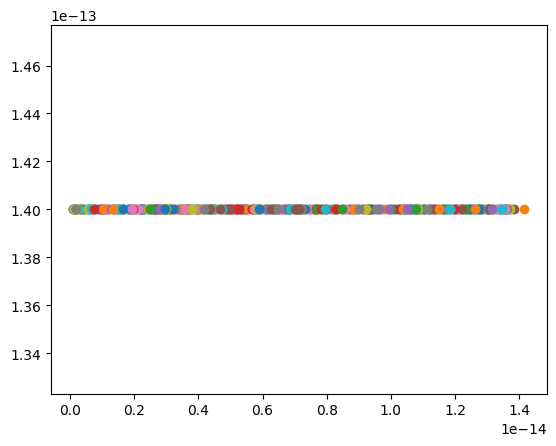

In [52]:
for num in tqdm(range(500)):
    x = X[num]  # shape: (10000,)
    x = torch.tensor(x).unsqueeze(0).float()  # (1, 10000)
    Y = torch.tensor(y[num]).squeeze(0).float()   # shape: (11, 10000)

    # Sum over species to reconstruct the mixed signal
    y_reconstructed = Y
    model.eval()
    with torch.inference_mode():
        output = model(x)
    plt.scatter(y_reconstructed, target_scaler.inverse_transform(output))